### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Breast Cancer Image Dataset Ultrasound.zip" -d "/content"

Archive:  /content/drive/MyDrive/Breast Cancer Image Dataset Ultrasound.zip
replace /content/Dataset/benign/benign (1).png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/Dataset/benign/benign (1).png  
  inflating: /content/Dataset/benign/benign (1)_mask.png  
  inflating: /content/Dataset/benign/benign (10).png  
  inflating: /content/Dataset/benign/benign (10)_mask.png  
  inflating: /content/Dataset/benign/benign (100).png  
  inflating: /content/Dataset/benign/benign (100)_mask.png  
  inflating: /content/Dataset/benign/benign (100)_mask_1.png  
  inflating: /content/Dataset/benign/benign (101).png  
  inflating: /content/Dataset/benign/benign (101)_mask.png  
  inflating: /content/Dataset/benign/benign (102).png  
  inflating: /content/Dataset/benign/benign (102)_mask.png  
  inflating: /content/Dataset/benign/benign (103).png  
  inflating: /content/Dataset/benign/benign (103)_mask.png  
  inflating: /content/Dataset/benign/benign (104).png  
  inflating: /content

### Import Necessary Modules

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import cv2
import sklearn
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import img_to_array
import tensorflow as tf

# Data Preprocessing

In [ ]:
# Set Image Properties
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

# Set path
path = 'Dataset/'

In [ ]:
size = 780 # Dataset size

In [ ]:
####### Make Dataset ####

## Benign ###

SIZE = 437
X = np.zeros((SIZE, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
y = np.zeros((SIZE, 1), dtype=np.float32)

i = 1
N = 0
while i <= SIZE:
    # Load images
    img = cv2.imread(path + '/benign/' + 'benign (' + str(i) + ')' + '.png')
    img = img_to_array(img)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode = 'constant', preserve_range = True)
    
    X[i] = img
    y[i] = label
    i += 1
    N += 1

  0%|          | 0/780 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7 ,random_state=5)

In [ ]:
num_classes = 3

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [ ]:
pretrained_base = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=X_train.shape[1:],
    pooling=max, classes=num_classes
)
pretrained_base.trainable = False

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.metrics import Precision
clf = keras.Sequential([
    pretrained_base,
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(2048, activation='tanh'),
    layers.Dense(1024, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(1024, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(512, activation='tanh'),
    layers.Dense(512, activation='tanh'),
    layers.Dense(3, activation='softmax'),
])

clf.compile(loss='categorical_crossentropy', 
            optimizer= keras.optimizers.Adam(learning_rate=0.0001), 
            metrics=['AUC','accuracy'])

In [ ]:
clf.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
dropout_34 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2048)              16779264  
_________________________________________________________________
dense_11 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)             

In [ ]:
################################
# Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('VGG16_Weights.h5', verbose=3, save_best_only=True)

callbacks = [
        checkpointer,
        tf.keras.callbacks.EarlyStopping(patience=100, monitor='val_loss', mode='min'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [ ]:
history = clf.fit(X_train, y_train ,epochs=100, callbacks=callbacks, validation_split=0.2)

Epoch 1/100
16/16 [==============================] - 6s 297ms/step - loss: 0.7063 - auc: 0.8883 - accuracy: 0.7475 - val_loss: 0.1455 - val_auc: 0.9957 - val_accuracy: 0.9600

Epoch 00001: val_loss improved from inf to 0.14553, saving model to VGG16_Weights.h5
Epoch 2/100
16/16 [==============================] - 2s 112ms/step - loss: 0.1688 - auc: 0.9906 - accuracy: 0.9539 - val_loss: 0.0579 - val_auc: 0.9990 - val_accuracy: 0.9840

Epoch 00002: val_loss improved from 0.14553 to 0.05790, saving model to VGG16_Weights.h5
Epoch 3/100
16/16 [==============================] - 2s 113ms/step - loss: 0.1033 - auc: 0.9963 - accuracy: 0.9719 - val_loss: 0.0772 - val_auc: 0.9966 - val_accuracy: 0.9760

Epoch 00003: val_loss did not improve from 0.05790
Epoch 4/100
16/16 [==============================] - 2s 132ms/step - loss: 0.0820 - auc: 0.9972 - accuracy: 0.9760 - val_loss: 0.0543 - val_auc: 0.9986 - val_accuracy: 0.9840

Epoch 00004: val_loss improved from 0.05790 to 0.05426, saving model to

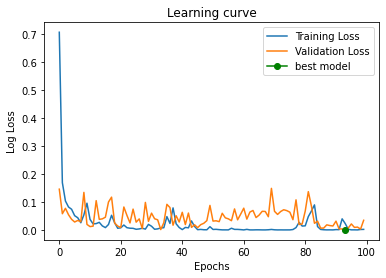

In [ ]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="o", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.legend();

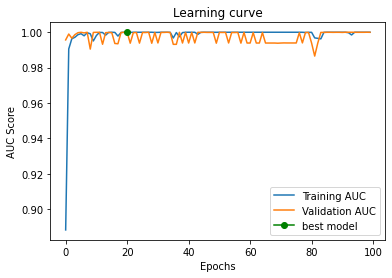

In [ ]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve")
plt.plot(history.history["auc"], label="Training AUC")
plt.plot(history.history["val_auc"], label="Validation AUC")
plt.plot(np.argmax(history.history["val_auc"]), np.max(history.history["val_auc"]), marker="o", color="g", label="best model")
plt.xlabel("Epochs")
plt.ylabel("AUC Score")
plt.legend();

In [ ]:
clf.save("VGG16 Classification Model.h5")